 # Using PointChargeCEF to fit INS of $\mathrm{Tb_3Mg_2Sb_3O_{14}}$
By Zhiling Dun, Jan. 2021

In [2]:
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
sys.path.append("/Users/dunzhiling/Documents/Research/Program/Python/PointChargeFit/arXivProgram/")
import PointChargeCEF_Oct2020 as CEF


# creast a CEFmodel object named EMSO
TMSO=CEF.CEFmodel('Tb3+')

# prepare dataset from files
Exp_1 = np.loadtxt("Exp_Tb-tripod_30meV_5K.dat", skiprows=1, usecols=[0,1,2])     #INS data
Exp_2 = np.loadtxt("Exp_Tb-tripod_30meV_100K.dat", skiprows=1, usecols=[0,1,2])     #INS data
Exp_3 = np.loadtxt("Exp_Tb-tripod_60meV_5K.dat", skiprows=1, usecols=[0,1,2])     #INS data
Exp_4 = np.loadtxt("Exp_Tb-tripod_60meV_100K.dat", skiprows=1, usecols=[0,1,2])     #INS data
Exp_sus = np.loadtxt("Exp_Tb-tripod_susceptibility.dat", skiprows=1)     #susceptibility data
Exp_MH_5K = np.loadtxt("Exp_Tb-tripod_MH.dat", skiprows=102, max_rows=99,  usecols=[1,2])     # MH data
Exp_MH_10K = np.loadtxt("Exp_Tb-tripod_MH.dat", skiprows=202, max_rows=99,usecols=[1,2])     # MH data
Exp_MH_40K = np.loadtxt("Exp_Tb-tripod_MH.dat", skiprows=402, max_rows=99,usecols=[1,2])     # MH data

#input observed Energy levels, put 0 for uncertain levels. 
TMSO.levels_obs=[0, 0, 2.5, 2.5, 16, 19, 0, 34, 0, 0, 0, 0, 0]  
#TMSO.levels_obs=[0, 0, 2.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  

# input 6 inelastic neutron scattering data, one susceptibility data, thre Magnetization file
TMSO.addINSdata(Exp_1,  Ei = 30,   Temperature = 5,     SpecialFWHM=[1,5,0.6] ) #
TMSO.addINSdata(Exp_2,  Ei = 30,   Temperature = 100,   SpecialFWHM=[1,5,0.6])
TMSO.addINSdata(Exp_3,  Ei = 60,   Temperature = 5   )
TMSO.addINSdata(Exp_4,  Ei = 60,   Temperature = 100 )
TMSO.addSUSdata(Exp_sus, B=0.1, Field=[0,0,0]) # powder
TMSO.addMHdata(Exp_MH_5K, Temperature=5, Field=[0,0,0]) # MH 5K
TMSO.addMHdata(Exp_MH_10K, Temperature=10, Field=[0,0,0]) # MH 5K
TMSO.addMHdata(Exp_MH_40K, Temperature=40, Field=[0,0,0]) # MH 5K

# create a point charge model, PC_variable stores the names of the PC variables, PC_value stores the numerical values
# then add 8 Point charge in spherical coordination
TMSO.PC_variable = 'R1', 'R2', 'R3', 'Theta2', 'Theta3', 'Phi', 'q1', 'q2', 'q3'

TMSO.clearPC()
TMSO.addPC('R1, 0, 0, q1')
TMSO.addPC('R1, 180, 0, q1')
TMSO.addPC('R2, Theta2, Phi, q2')
TMSO.addPC('R2, Theta2, 360-Phi, q2')
TMSO.addPC('R2, 180-Theta2, 180-Phi, q2')
TMSO.addPC('R2, 180-Theta2, 180+Phi, q2')
TMSO.addPC('R3, 180-Theta3, 0, q3')
TMSO.addPC('R3, Theta3, 180, q3')



## Plot  inelastic neutron scattering pattern from Initial PC parameters 

[ 0.     0.081  1.833  2.958 14.856 18.272 34.555 35.489 42.108 49.17  59.042 69.741 72.402]
 Rotational matrix =  
 [[ 0.979  0.     0.202]
 [ 0.     1.     0.   ]
 [-0.202  0.     0.979]] 
 Rotation angle = 11.66492544880914 

g_diagnal =  
 [[-0.     0.    -0.   ]
 [ 0.    -0.     0.   ]
 [-0.     0.    14.495]]


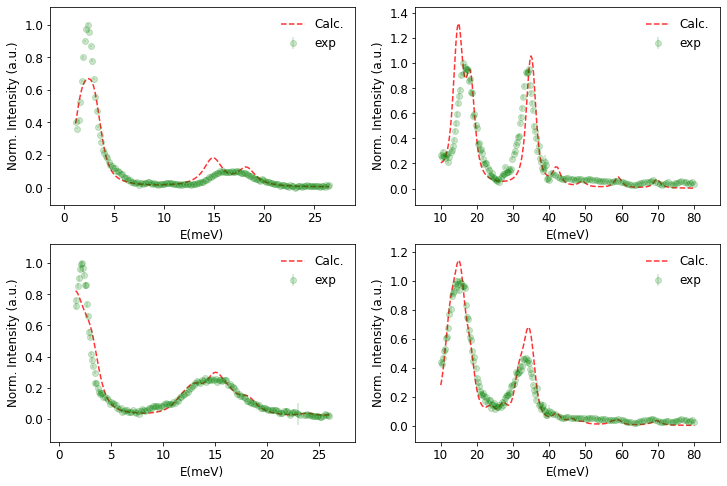

In [3]:
TMSO.PC_value_ini = np.array([1.8, 1.6, 1.6, 80, 76, 59, 0.5, 0.30, 0.15]) 
TMSO.PC_value_ini = np.array([ 1.77, 1.64,  1.42, 82.,   80.,   58.,    0.6,   0.3,   0.14])
#TMSO.PC_value_ini = np.array([1.68,  1.63, 1.5, 82.8, 75.2, 55.2, 0.5, 0.3, 0.15])


TMSO.FWHM=1

# define a function to plot 6 INS pattern together
# Evaluate_pattern(dataset = i, Plotcontrol=True, UsePCini=True) automatically plot a singel INS dataset and return the Chi^2 of calcualted pattern 
# if UsePCini = True, use
def PlotINS(cls, control=False):
    plt.figure(figsize=(12,8))
    for i in range(2):
        plt.subplot(2,2,1+i*2)
        chi,x,y = cls.Evaluate_pattern(dataset = i, Plotcontrol=True, UsePCini=control)
    for i in range(2,4):
        plt.subplot(2,2,i*2-2)
        chi,x,y = cls.Evaluate_pattern(dataset = i, Plotcontrol=True, UsePCini=control)

PlotINS(TMSO, True)

np.set_printoptions(precision=3, suppress=True, linewidth=100)
print(TMSO.eigenval)
TMSO.diagonalG();

## Search parameter space

In [4]:
# for-loops grid search within given Boundary of parameter space
# Boundary = [np.linspace(1.6, 1.7, 3),
#             np.linspace(1.4, 1.6, 3),
#             np.linspace(1.4, 1.6, 3),
#             np.linspace(75, 85, 3),
#             np.linspace(75, 85, 3),
#             np.linspace(55, 65, 3),
#             np.linspace(0.5, 0.5, 1),
#             np.linspace(0.35, 0.15, 5),
#             np.linspace(0.35, 0.15, 5),
#            ]

# Boundary = [np.linspace(1.76, 1.78, 3),
#             np.linspace(1.62, 1.64, 3),
#             np.linspace(1.38, 1.42, 3),
#             np.linspace(78, 82, 3),
#             np.linspace(80, 80, 1),
#             np.linspace(56, 58, 2),
#             np.linspace(0.6, 0.6, 1),
#             np.linspace(0.28, 0.3, 3),
#             np.linspace(0.12, 0.16, 3),
#            ]
# TMSO.PCsearch(Boundary, "TMSO_PCsearch5.dat")

'Done!'

##  Point Charge fit

[ 1.77  1.64  1.42 82.   80.   58.    0.6   0.3   0.14]
Function 729 evaluated, Chi2_energy =    0.0574 ,  Chi2 =    1.5453                                                                                

Eigen-enerigies =  [ 0.     0.06   2.263  2.452 15.601 18.385 33.519 34.162 41.137 52.601 61.864 69.4   72.773]
 Rotational matrix =  
 [[ 1.     0.     0.017]
 [ 0.     1.     0.   ]
 [-0.017  0.     1.   ]] 
 Rotation angle = 0.9730547815265314 

g_diagnal =  
 [[  0.      0.     -0.   ]
 [  0.     -0.      0.   ]
 [  0.      0.    -14.254]]


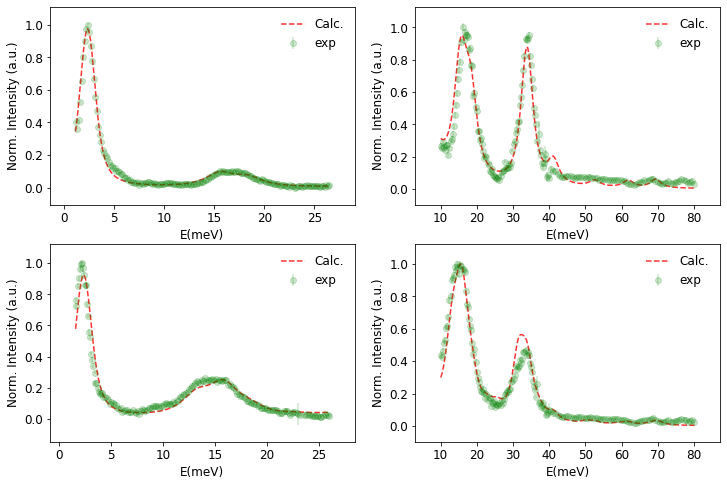

In [4]:
# use default method ('Nelder-Mead') to fine mininum, PC_values are automatically updated
PCSearch = np.loadtxt("TMSO_PCsearch5.dat", skiprows=1)     
TMSO.PC_value_ini=PCSearch[1][1:]
print(TMSO.PC_value_ini)

# np.set_printoptions(precision=3, suppress=True, linewidth=100)
# print(TMSO.eigenval)
# TMSO.diagonalG();

#TMSO.PCfit(Fit_variable=['R1', 'R2', 'R3', 'Theta2', 'Theta3', 'Phi','FWHM'])   
TMSO.PCfit()

print("\n\nEigen-enerigies = ",TMSO.eigenval)
PlotINS(TMSO) # check new fit
TMSO.diagonalG();

In [5]:
TMSO.writefile("TMSO_PCfit_solution.dat");  # wirte results to a data file named "EMSO_PCfit1.dat"

## Calculate susceptibility 

Read Bkq successfully for  Tb3+ , Number of Steven Operator = 15 , in the unit of meV
[[ 2.     0.    -0.401]
 [ 2.     1.     0.063]
 [ 2.     2.     0.247]
 [ 4.     0.     0.004]
 [ 4.     1.    -0.001]
 [ 4.     2.     0.001]
 [ 4.     3.     0.027]
 [ 4.     4.    -0.006]
 [ 6.     0.    -0.   ]
 [ 6.     1.    -0.   ]
 [ 6.     2.     0.   ]
 [ 6.     3.     0.   ]
 [ 6.     4.    -0.   ]
 [ 6.     5.    -0.   ]
 [ 6.     6.    -0.   ]]
0.30772227739364094
0.5444518296183026
0.7588893851715074
0.9599142866919186
1.155789101583105
1.3503780339611573
1.5449710785547393
1.7397521601883195
1.9345160043059106
2.128967455902211
2.3228339686113277
2.5159005382842996
2.708013899167749
2.8990754807304846
3.089031168758359
4.0222692226988555
4.931374632038108
5.82211828659731
6.699183981857084
7.565906684476291
8.424663147072716
9.277202673950681
10.124855707337842
10.96866014270293
11.809440138192532
12.64785781467261
13.484448959426336
14.319648837514688
15.153811584765664
15.98722523089

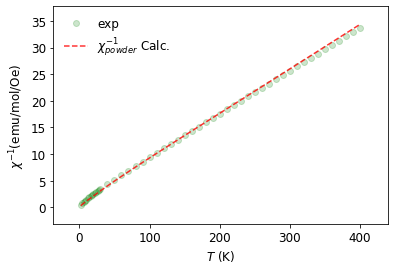

In [7]:
# Power inverse suceptibility without Weiss_field correction
TMSO.readBkq("TMSO_PCfit_solution.dat")
x,y=TMSO.Powder_InverseSusceptibility(B=0.1, dataset=0)
for i in range(len(y)):
    print(y[i])

0.7522224626713482
0.9489859205553846
1.130097022509811
1.3078829922429003
1.4864116990435448
1.6653394873715845
1.853931130692944
2.0397641505310675
2.228363083747977
2.4180313096658654
2.6100929543209
2.7971615377007413
2.9860490109362066
3.17423090310628
3.3615523072839864
4.284360361670045
5.19770992662212
6.079743623594244
6.942944750811015
7.80596073419599
8.661512085776227
9.511395138471308
10.356876010985824
11.19887631598782
12.038026485494518
12.874904957322974
13.710135044750736
14.544167859829798
15.377122107520478
16.209139648710142
17.04145215480311
17.87319875556808
18.70506597857913
19.536295802041714
20.367816339105758
21.198979453341014
22.03181460689615
22.864049283823284
23.69542499314897
24.528921225966137
25.361638232658645
26.1959183299452
27.029717451406423
27.86313270664854
28.699800468387384
29.534196222752563
30.370264117341
31.204541430955807
32.04195250033566
32.87694076959756
33.00721239888694
34.5496977002641


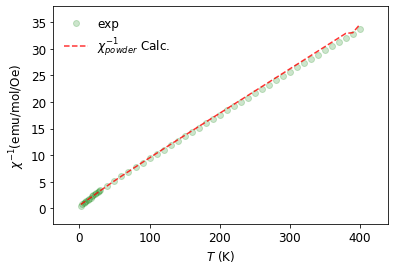

In [8]:
# Power inverse suceptibility with Weiss_field correction
x,y=TMSO.Powder_InverseSusceptibility(B=0.1, dataset=0, Weiss_field=0.2)
for i in range(len(y)):
    print(y[i])

##  Calculate  MH-curve

The power-averaging might take quite with the Weiss_field Correaction


(array([ 0.       ,  1.5555556,  3.1111111,  4.6666667,  6.2222222,  7.7777778,  9.3333333,
        10.8888889, 12.4444444, 14.       ]),
 array([0.       , 3.2233754, 4.5412622, 5.2113891, 5.6234143, 5.8997858, 6.0989174, 6.2513919,
        6.3739055, 6.4760404]))

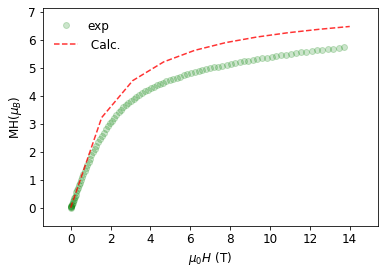

In [12]:
H = np.linspace(0,14,10)
TMSO.Powder_Magnetization(dataset=0, B_range=H, intergration_step=6)

H(T)    M_powder(5K), M_powder(10K), M_powder(40K)
[0. 0. 0. 0.]
[1.        2.4100827 1.4955539 0.4436532]
[2.        3.7568262 2.7359723 0.8821329]
[3.        4.470304  3.6531095 1.3105889]
[4.        4.9174699 4.3073078 1.7247692]
[5.        5.2363576 4.7788365 2.1212129]
[6.        5.4802363 5.1283995 2.4973439]
[7.        5.6740575 5.3958681 2.8514723]
[8.        5.8319844 5.6067085 3.1827228]
[9.        5.963182  5.7773594 3.4909164]
[10.         6.0740323  5.9186804  3.7764311]
[11.         6.169151   6.0380362  4.0400619]
[12.         6.2519462  6.1405528  4.2828932]
[13.         6.3249666  6.2298877  4.5061903]
[14.         6.3901372  6.3087111  4.7113138]
Time used: 0:00:16.457287


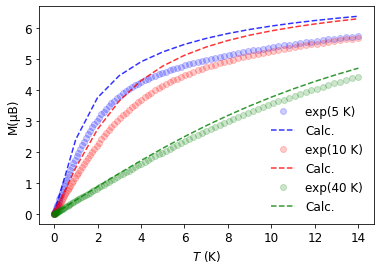

In [13]:
Field = np.linspace(0,14,15)
MH=np.zeros((len(Field),len(TMSO.EXP_MH)+1))
MH[:,0]=Field

time1=datetime.now()
print('H(T)    M_powder(5K), M_powder(10K), M_powder(40K)')
for i in range(len(Field)):
    for j in range(len(TMSO.EXP_MH)):        
        MH[i][j+1]= float(TMSO.Powder_Magnetization(dataset=j, B_range=[Field[i]], Weiss_field=0.0 ,intergration_step=10, Plotcontrol=False)[1])      
    print(MH[i])
print('Time used:', datetime.now()-time1)

color=['b','r', 'g']
for i in range(len(TMSO.EXP_MH)):
    plt.plot(TMSO.EXP_MH[i].x, TMSO.EXP_MH[i].y, 'o', color=color[i], alpha=0.2, label='exp(%d K)' %TMSO.EXP_MH[i].Temperature);
    plt.plot(MH[:,0], MH[:,i+1], '--', color=color[i], alpha=0.8, label='Calc.');
Frontsize=12
plt.legend(loc='lower right', frameon=False,fontsize=Frontsize)    
plt.xlabel('$T$ (K)',fontsize=Frontsize);
plt.ylabel('M(μB)',fontsize=Frontsize);
plt.xticks(fontsize=Frontsize);
plt.yticks(fontsize=Frontsize);

In [ ]:
0. 0. 0. 0.
1.        2.4100827 1.4955539 0.4436532
2.        3.7568262 2.7359723 0.8821329
3.        4.470304  3.6531095 1.3105889
4.        4.9174699 4.3073078 1.7247692
5.        5.2363576 4.7788365 2.1212129
6.        5.4802363 5.1283995 2.4973439
7.        5.6740575 5.3958681 2.8514723
8.        5.8319844 5.6067085 3.1827228
9.        5.963182  5.7773594 3.4909164
10.         6.0740323  5.9186804  3.7764311
11.         6.169151   6.0380362  4.0400619
12.         6.2519462  6.1405528  4.2828932
13.         6.3249666  6.2298877  4.5061903
14.         6.3901372  6.3087111  4.7113138

H(T)    M_powder(5K), M_powder(10K), M_powder(40K)
[0. 0. 0. 0.]
[1.        1.6705398 1.1872654 0.4167089]
[2.        3.06232   2.277627  0.8295255]
[3.        4.0137548 3.1988884 1.2347277]
[4.        4.6136582 3.9250582 1.6289191]
[5.        5.0144552 4.4753413 2.009156 ]
[6.        5.3037565 4.8893451 2.3730366]
[7.        5.5264168 5.2049188 2.7187482]
[8.        5.7062023 5.4506674 3.0450702]
[9.        5.8559661 5.6466181 3.3513425]
[10.         5.9831496  5.806573   3.6374027]
[11.         6.0925317  5.9400626  3.9035076]
[12.         6.1875118  6.0537073  4.1502462]
[13.         6.2707001  6.1521462  4.3784544]
[14.         6.3441901  6.2386718  4.5891362]
Time used: 0:42:57.048351


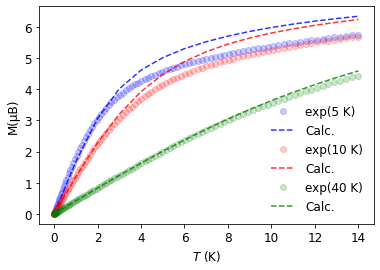

In [15]:
# with Weiss field correction
time1=datetime.now()
print('H(T)    M_powder(5K), M_powder(10K), M_powder(40K)')
for i in range(len(Field)):
    for j in range(len(TMSO.EXP_MH)):        
        MH[i][j+1]= float(TMSO.Powder_Magnetization(dataset=j, B_range=[Field[i]], Weiss_field=0.2 ,intergration_step=10, Plotcontrol=False)[1])      
    print(MH[i])
print('Time used:', datetime.now()-time1)

color=['b','r', 'g']
for i in range(len(TMSO.EXP_MH)):
    plt.plot(TMSO.EXP_MH[i].x, TMSO.EXP_MH[i].y, 'o', color=color[i], alpha=0.2, label='exp(%d K)' %TMSO.EXP_MH[i].Temperature);
    plt.plot(MH[:,0], MH[:,i+1], '--', color=color[i], alpha=0.8, label='Calc.');
Frontsize=12
plt.legend(loc='lower right', frameon=False,fontsize=Frontsize)    
plt.xlabel('$T$ (K)',fontsize=Frontsize);
plt.ylabel('M(μB)',fontsize=Frontsize);
plt.xticks(fontsize=Frontsize);
plt.yticks(fontsize=Frontsize);